### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

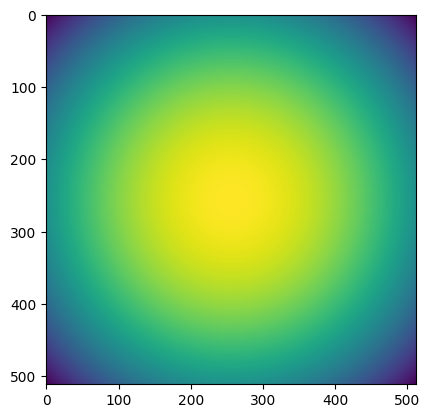

In [1]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 512 #[256, 512, 1024]



##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] 


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [2]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5


Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

#### Normalization:

$$
A_c / L^2
$$

$$
t / \tau_1
$$

$$
F_N /\left(E^* L^2 h^\prime_{\mathrm{rms}}\right)
$$

In [3]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#normalized pressure
h_rms_prime = tm.Statistics2D.computeSpectralRMSSlope(surface)
'''
p_target = p_target / (E_star*h_rms_prime)
'''

Fn_Johnson = W / (E_star*h_rms_prime)

#solver.solve(p_target)
time_steps_list = np.geomspace(4,800,10 , dtype=int)#[2, 20, 30, 50, 80, 100, 150, 250, 400, 800, 1200, 1600]
#L2_norms = []
error_list = []

##time
t0 = 0
t1 = 10 
## normalized time
t0 = 0/np.min(characteristic_time)
t1 = 10/np.min(characteristic_time)



In [4]:
##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

 Iter          Cost_f           Error


    0    3.812270e-02    5.307897e-01
   95    1.002821e+00    6.971223e-13
 Iter          Cost_f           Error
    0    5.350158e-01    1.074337e-02
   70    1.258170e+00    6.373430e-13
 Iter          Cost_f           Error
    0    6.009892e-01    3.974332e-03
   84    1.358877e+00    7.033041e-13
 Iter          Cost_f           Error
    0    6.292350e-01    1.385451e-03
   79    1.399924e+00    8.021553e-13


[np.float64(0.040485382080078125), np.float64(0.044712066650390625), np.float64(0.046482086181640625)]
[np.float64(0.04309094174405238), np.float64(0.04645334168481716), np.float64(0.04739428799215573)]
3
3


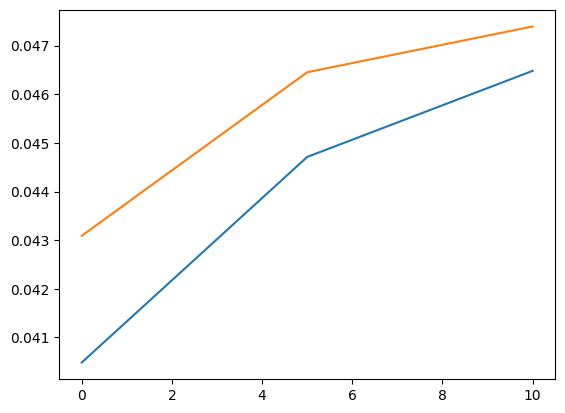

 Iter          Cost_f           Error
    0    3.152038e-01    1.319269e-02
   84    1.039437e+00    3.561316e-13
 Iter          Cost_f           Error
    0    5.709231e-01    1.080967e-02
   79    1.326237e+00    8.661750e-13
 Iter          Cost_f           Error
    0    6.748776e-01    5.545741e-03
   77    1.476841e+00    8.456707e-13
 Iter          Cost_f           Error
    0    7.319162e-01    2.751279e-03
   85    1.557934e+00    7.444659e-13
 Iter          Cost_f           Error
    0    7.632834e-01    1.342742e-03
   79    1.602361e+00    6.696867e-13
 Iter          Cost_f           Error
    0    7.806326e-01    6.363032e-04
   77    1.627015e+00    6.748900e-13
 Iter          Cost_f           Error
    0    7.902865e-01    3.061689e-04
   71    1.640844e+00    5.993508e-13


[np.float64(0.038074493408203125), np.float64(0.042255401611328125), np.float64(0.044620513916015625), np.float64(0.045932769775390625), np.float64(0.046817779541015625), np.float64(0.047153472900390625)]
[np.float64(0.03961593326084388), np.float64(0.04387292296553237), np.float64(0.04588265332696761), np.float64(0.04685055984194041), np.float64(0.04732075687161024), np.float64(0.04755008753641947)]
6
6


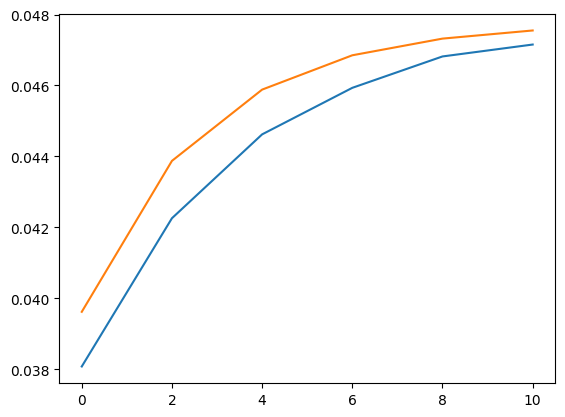

 Iter          Cost_f           Error
    0    3.125863e-01    1.523659e-02
   80    1.075963e+00    7.751248e-13
 Iter          Cost_f           Error
    0    5.744062e-01    9.586638e-03
   78    1.354919e+00    9.633777e-13
 Iter          Cost_f           Error
    0    7.035129e-01    6.165583e-03
   83    1.535478e+00    6.889587e-13
 Iter          Cost_f           Error
    0    7.889171e-01    3.893253e-03
   84    1.654255e+00    9.033872e-13
 Iter          Cost_f           Error
    0    8.457822e-01    2.422810e-03
   83    1.733382e+00    6.660228e-13
 Iter          Cost_f           Error
    0    8.838674e-01    1.511015e-03
   79    1.786610e+00    8.905519e-13
 Iter          Cost_f           Error
    0    9.095241e-01    9.333700e-04
   78    1.822688e+00    8.905382e-13
 Iter          Cost_f           Error
    0    9.269054e-01    5.807959e-04
   73    1.847307e+00    9.050171e-13
 Iter          Cost_f           Error
    0    9.387428e-01    3.563792e-04
   69    1.8

[np.float64(0.035861968994140625), np.float64(0.039600372314453125), np.float64(0.042148590087890625), np.float64(0.043888092041015625), np.float64(0.045017242431640625), np.float64(0.045871734619140625), np.float64(0.046482086181640625), np.float64(0.046878814697265625), np.float64(0.047153472900390625), np.float64(0.047306060791015625), np.float64(0.047382354736328125)]
[np.float64(0.036590186021927006), np.float64(0.04057089682651544), np.float64(0.04309094174405238), np.float64(0.04471256428338764), np.float64(0.045765674621851916), np.float64(0.04645334168481716), np.float64(0.04690390707125092), np.float64(0.04719975756773412), np.float64(0.04739428799215573), np.float64(0.04752231225071476), np.float64(0.047606616797847154)]
11
11


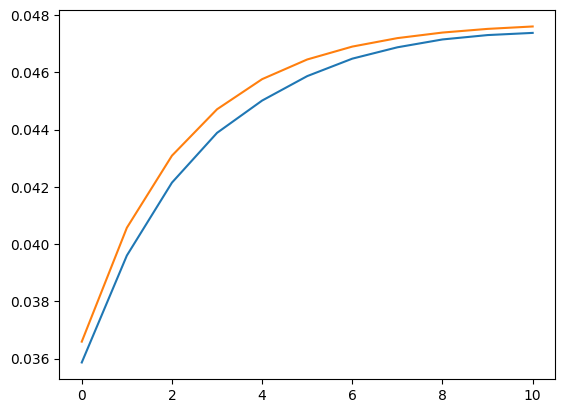

 Iter          Cost_f           Error
    0    3.100300e-01    1.682056e-02
   70    1.114894e+00    8.592709e-13
 Iter          Cost_f           Error
    0    5.416689e-01    7.167858e-03
   75    1.340793e+00    6.603998e-13
 Iter          Cost_f           Error
    0    6.699742e-01    5.542782e-03
   75    1.515351e+00    7.513496e-13
 Iter          Cost_f           Error
    0    7.697340e-01    4.233661e-03
   77    1.651156e+00    6.406840e-13
 Iter          Cost_f           Error
    0    8.476951e-01    3.241104e-03
   76    1.757536e+00    9.530859e-13
 Iter          Cost_f           Error
    0    9.088980e-01    2.467552e-03
   79    1.841347e+00    8.211992e-13
 Iter          Cost_f           Error
    0    9.571433e-01    1.864822e-03
   74    1.907692e+00    9.559038e-13
 Iter          Cost_f           Error
    0    9.953090e-01    1.417104e-03
   69    1.960434e+00    6.821117e-13
 Iter          Cost_f           Error
    0    1.025587e+00    1.075783e-03
   75    2.0

[np.float64(0.033664703369140625), np.float64(0.036457061767578125), np.float64(0.038578033447265625), np.float64(0.040332794189453125), np.float64(0.041690826416015625), np.float64(0.042804718017578125), np.float64(0.043766021728515625), np.float64(0.044483184814453125), np.float64(0.045108795166015625), np.float64(0.045566558837890625), np.float64(0.045948028564453125), np.float64(0.046344757080078125), np.float64(0.046604156494140625), np.float64(0.046878814697265625), np.float64(0.046970367431640625), np.float64(0.047153472900390625), np.float64(0.047275543212890625), np.float64(0.047306060791015625), np.float64(0.047336578369140625), np.float64(0.047534942626953125), np.float64(0.047565460205078125), np.float64(0.047657012939453125)]
[np.float64(0.033895021268878084), np.float64(0.03680519797594616), np.float64(0.03906549885022917), np.float64(0.040837656361117775), np.float64(0.04223607373379916), np.float64(0.04334465298492078), np.float64(0.04422643515322445), np.float64(0.0449

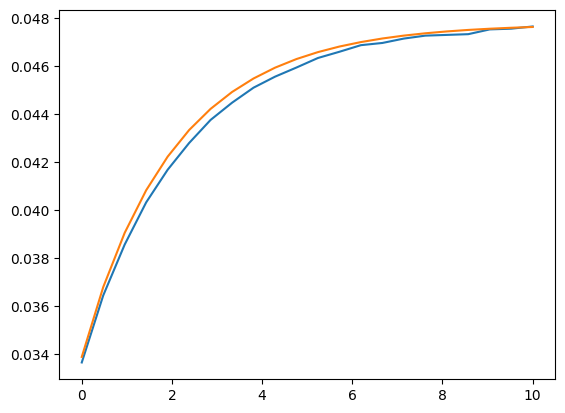

 Iter          Cost_f           Error
    0    3.082370e-01    1.768383e-02
   83    1.141906e+00    6.250789e-13
 Iter          Cost_f           Error
    0    4.963682e-01    4.848419e-03
   77    1.302617e+00    7.694780e-13
 Iter          Cost_f           Error
    0    5.992894e-01    4.172392e-03
   80    1.440628e+00    9.781577e-13
 Iter          Cost_f           Error
    0    6.877497e-01    3.573060e-03
   79    1.559427e+00    9.015957e-13
 Iter          Cost_f           Error
    0    7.639108e-01    3.042588e-03
   81    1.661944e+00    8.849809e-13
 Iter          Cost_f           Error
    0    8.296395e-01    2.594625e-03
   80    1.750644e+00    5.880157e-13
 Iter          Cost_f           Error
    0    8.864851e-01    2.213519e-03
   78    1.827584e+00    7.482659e-13
 Iter          Cost_f           Error
    0    9.357521e-01    1.892462e-03
   73    1.894487e+00    8.918175e-13
 Iter          Cost_f           Error
    0    9.785297e-01    1.602596e-03
   81    1.9

[np.float64(0.032276153564453125), np.float64(0.034183502197265625), np.float64(0.035739898681640625), np.float64(0.037113189697265625), np.float64(0.038288116455078125), np.float64(0.039478302001953125), np.float64(0.040332794189453125), np.float64(0.041095733642578125), np.float64(0.041934967041015625), np.float64(0.042591094970703125), np.float64(0.043064117431640625), np.float64(0.043643951416015625), np.float64(0.044071197509765625), np.float64(0.044483184814453125), np.float64(0.044925689697265625), np.float64(0.045230865478515625), np.float64(0.045413970947265625), np.float64(0.045719146728515625), np.float64(0.045932769775390625), np.float64(0.046161651611328125), np.float64(0.046344757080078125), np.float64(0.046573638916015625), np.float64(0.046726226806640625), np.float64(0.046817779541015625), np.float64(0.046878814697265625), np.float64(0.046909332275390625), np.float64(0.047122955322265625), np.float64(0.047153472900390625), np.float64(0.047214508056640625), np.float64(0.

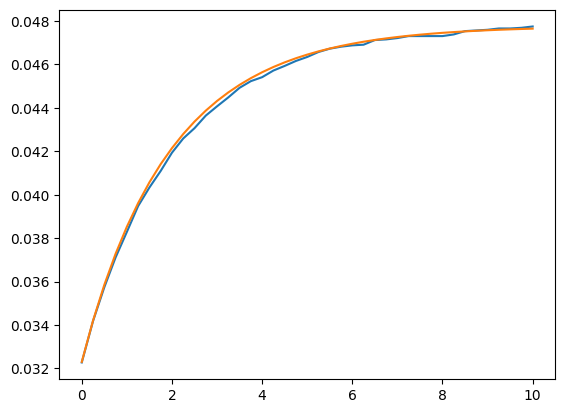

 Iter          Cost_f           Error
    0    3.071103e-01    1.816859e-02
   73    1.159506e+00    6.935180e-13
 Iter          Cost_f           Error
    0    4.569437e-01    3.081525e-03
   76    1.264679e+00    8.181987e-13
 Iter          Cost_f           Error
    0    5.291896e-01    2.823483e-03
   76    1.360895e+00    5.268369e-13
 Iter          Cost_f           Error
    0    5.952458e-01    2.585858e-03
   75    1.448979e+00    4.661771e-13
 Iter          Cost_f           Error
    0    6.556826e-01    2.355717e-03
   70    1.529674e+00    8.237951e-13
 Iter          Cost_f           Error
    0    7.110232e-01    2.150861e-03
   73    1.603662e+00    7.002618e-13
 Iter          Cost_f           Error
    0    7.617160e-01    1.959513e-03
   74    1.671583e+00    5.068566e-13
 Iter          Cost_f           Error
    0    8.082102e-01    1.776309e-03
   75    1.733966e+00    6.874873e-13
 Iter          Cost_f           Error
    0    8.508708e-01    1.619765e-03
   79    1.7

[np.float64(0.031482696533203125), np.float64(0.032566070556640625), np.float64(0.033603668212890625), np.float64(0.034564971923828125), np.float64(0.035526275634765625), np.float64(0.036334991455078125), np.float64(0.037113189697265625), np.float64(0.037860870361328125), np.float64(0.038516998291015625), np.float64(0.039112091064453125), np.float64(0.039691925048828125), np.float64(0.040119171142578125), np.float64(0.040790557861328125), np.float64(0.041187286376953125), np.float64(0.041584014892578125), np.float64(0.042057037353515625), np.float64(0.042407989501953125), np.float64(0.042774200439453125), np.float64(0.042987823486328125), np.float64(0.043369293212890625), np.float64(0.043643951416015625), np.float64(0.043949127197265625), np.float64(0.044101715087890625), np.float64(0.044391632080078125), np.float64(0.044620513916015625), np.float64(0.044864654541015625), np.float64(0.045017242431640625), np.float64(0.045291900634765625), np.float64(0.045383453369140625), np.float64(0.

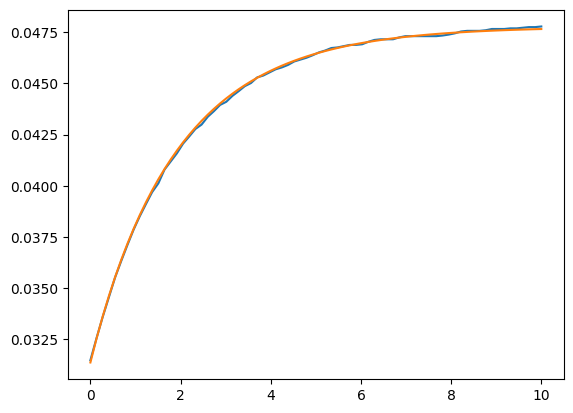

 Iter          Cost_f           Error
    0    3.064429e-01    1.845410e-02
   73    1.170841e+00    9.522800e-13
 Iter          Cost_f           Error
    0    4.275593e-01    1.831348e-03
   71    1.234631e+00    6.648826e-13
 Iter          Cost_f           Error
    0    4.732026e-01    1.746162e-03
   77    1.295286e+00    9.498731e-13
 Iter          Cost_f           Error
    0    5.166223e-01    1.658353e-03
   75    1.352978e+00    8.842071e-13
 Iter          Cost_f           Error
    0    5.578818e-01    1.577689e-03
   73    1.407857e+00    8.879115e-13
 Iter          Cost_f           Error
    0    5.971223e-01    1.498851e-03
   73    1.460070e+00    7.332312e-13
 Iter          Cost_f           Error
    0    6.344381e-01    1.421488e-03
   72    1.509765e+00    9.841421e-13
 Iter          Cost_f           Error
    0    6.699232e-01    1.350100e-03
   77    1.557065e+00    8.867894e-13
 Iter          Cost_f           Error
    0    7.036870e-01    1.282913e-03
   74    1.6

[np.float64(0.030872344970703125), np.float64(0.031635284423828125), np.float64(0.032123565673828125), np.float64(0.032855987548828125), np.float64(0.033435821533203125), np.float64(0.034030914306640625), np.float64(0.034488677978515625), np.float64(0.035007476806640625), np.float64(0.035587310791015625), np.float64(0.035984039306640625), np.float64(0.036472320556640625), np.float64(0.036960601806640625), np.float64(0.037265777587890625), np.float64(0.037830352783203125), np.float64(0.038135528564453125), np.float64(0.038486480712890625), np.float64(0.038791656494140625), np.float64(0.039142608642578125), np.float64(0.039508819580078125), np.float64(0.039783477783203125), np.float64(0.040058135986328125), np.float64(0.040393829345703125), np.float64(0.040668487548828125), np.float64(0.040943145751953125), np.float64(0.041187286376953125), np.float64(0.041370391845703125), np.float64(0.041629791259765625), np.float64(0.041934967041015625), np.float64(0.042148590087890625), np.float64(0.

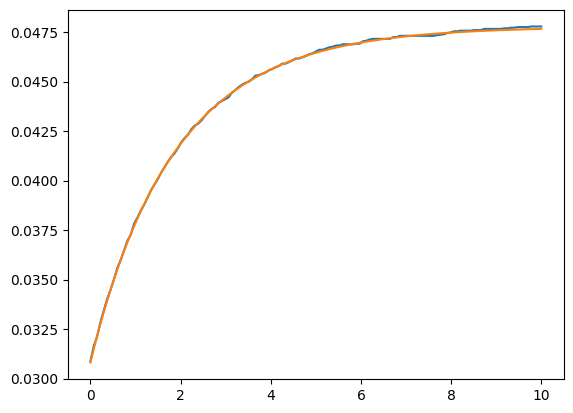

 Iter          Cost_f           Error
    0    3.060074e-01    1.860934e-02
   71    1.177536e+00    5.602745e-13
 Iter          Cost_f           Error
    0    4.087816e-01    1.053668e-03
   70    1.214772e+00    7.052679e-13
 Iter          Cost_f           Error
    0    4.360441e-01    1.025504e-03
   66    1.250974e+00    7.499594e-13
 Iter          Cost_f           Error
    0    4.625520e-01    1.000818e-03
   69    1.286176e+00    5.375566e-13
 Iter          Cost_f           Error
    0    4.883317e-01    9.748773e-04
   72    1.320397e+00    9.703027e-13
 Iter          Cost_f           Error
    0    5.133804e-01    9.460923e-04
   69    1.353666e+00    9.145695e-13
 Iter          Cost_f           Error
    0    5.377240e-01    9.207770e-04
   73    1.386023e+00    9.191915e-13
 Iter          Cost_f           Error
    0    5.614057e-01    8.904557e-04
   69    1.417490e+00    7.739139e-13
 Iter          Cost_f           Error
    0    5.844255e-01    8.681558e-04
   69    1.4

[np.float64(0.030597686767578125), np.float64(0.030933380126953125), np.float64(0.031421661376953125), np.float64(0.031757354736328125), np.float64(0.032093048095703125), np.float64(0.032505035400390625), np.float64(0.032749176025390625), np.float64(0.033161163330078125), np.float64(0.033435821533203125), np.float64(0.033756256103515625), np.float64(0.034122467041015625), np.float64(0.034366607666015625), np.float64(0.034656524658203125), np.float64(0.034946441650390625), np.float64(0.035312652587890625), np.float64(0.035495758056640625), np.float64(0.035770416259765625), np.float64(0.036014556884765625), np.float64(0.036243438720703125), np.float64(0.036563873291015625), np.float64(0.036808013916015625), np.float64(0.037052154541015625), np.float64(0.037204742431640625), np.float64(0.037387847900390625), np.float64(0.037708282470703125), np.float64(0.037921905517578125), np.float64(0.038135528564453125), np.float64(0.038288116455078125), np.float64(0.038516998291015625), np.float64(0.

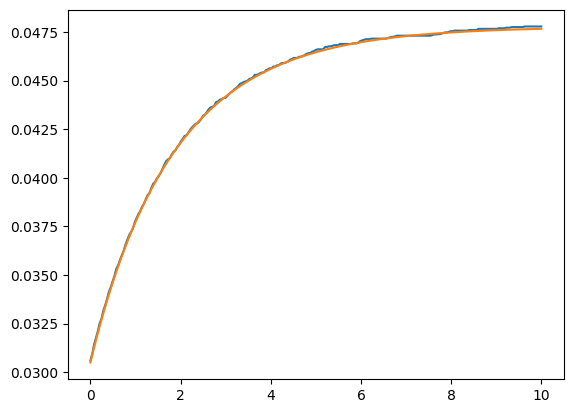

 Iter          Cost_f           Error
    0    3.057527e-01    1.869535e-02
   75    1.181380e+00    7.591337e-13
 Iter          Cost_f           Error
    0    3.975458e-01    5.986858e-04
   71    1.202656e+00    6.849668e-13
 Iter          Cost_f           Error
    0    4.133268e-01    5.896984e-04
   60    1.223600e+00    8.386500e-13
 Iter          Cost_f           Error
    0    4.288580e-01    5.800993e-04
   60    1.244208e+00    7.441142e-13
 Iter          Cost_f           Error
    0    4.441373e-01    5.732864e-04
   64    1.264504e+00    9.316199e-13
 Iter          Cost_f           Error
    0    4.591859e-01    5.643724e-04
   68    1.284487e+00    8.809920e-13
 Iter          Cost_f           Error
    0    4.740040e-01    5.552348e-04
   64    1.304156e+00    8.951899e-13
 Iter          Cost_f           Error
    0    4.885879e-01    5.469835e-04
   65    1.323516e+00    9.477370e-13
 Iter          Cost_f           Error
    0    5.029404e-01    5.371389e-04
   63    1.3

[np.float64(0.030475616455078125), np.float64(0.030628204345703125), np.float64(0.030841827392578125), np.float64(0.030979156494140625), np.float64(0.031360626220703125), np.float64(0.031543731689453125), np.float64(0.031696319580078125), np.float64(0.031848907470703125), np.float64(0.032093048095703125), np.float64(0.032276153564453125), np.float64(0.032535552978515625), np.float64(0.032749176025390625), np.float64(0.032886505126953125), np.float64(0.033130645751953125), np.float64(0.033252716064453125), np.float64(0.033344268798828125), np.float64(0.033527374267578125), np.float64(0.033786773681640625), np.float64(0.033969879150390625), np.float64(0.034152984619140625), np.float64(0.034305572509765625), np.float64(0.034427642822265625), np.float64(0.034549713134765625), np.float64(0.034778594970703125), np.float64(0.034915924072265625), np.float64(0.035068511962890625), np.float64(0.035312652587890625), np.float64(0.035404205322265625), np.float64(0.035587310791015625), np.float64(0.

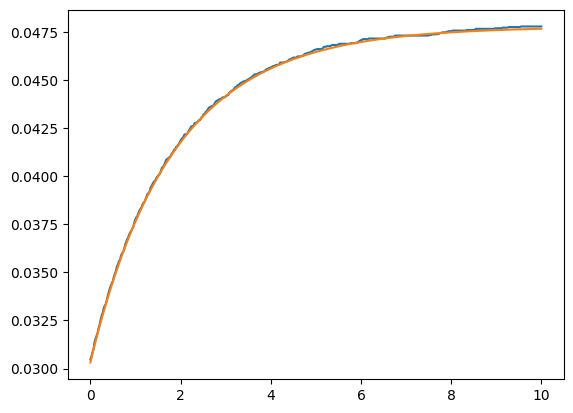

 Iter          Cost_f           Error
    0    3.056132e-01    1.874324e-02
   76    1.183551e+00    6.965707e-13
 Iter          Cost_f           Error
    0    3.910603e-01    3.370324e-04
   61    1.195568e+00    9.305072e-13
 Iter          Cost_f           Error
    0    4.000333e-01    3.335264e-04
   65    1.207476e+00    7.314133e-13
 Iter          Cost_f           Error
    0    4.089219e-01    3.313681e-04
   66    1.219279e+00    6.996362e-13
 Iter          Cost_f           Error
    0    4.177346e-01    3.287933e-04
   63    1.230981e+00    8.301583e-13
 Iter          Cost_f           Error
    0    4.264751e-01    3.260258e-04
   63    1.242578e+00    5.467545e-13
 Iter          Cost_f           Error
    0    4.351345e-01    3.234933e-04
   67    1.254071e+00    9.283317e-13
 Iter          Cost_f           Error
    0    4.437160e-01    3.194398e-04
   66    1.265464e+00    6.155531e-13
 Iter          Cost_f           Error
    0    4.522214e-01    3.189173e-04
   62    1.2

[np.float64(0.030384063720703125), np.float64(0.030475616455078125), np.float64(0.030597686767578125), np.float64(0.030689239501953125), np.float64(0.030841827392578125), np.float64(0.030902862548828125), np.float64(0.030933380126953125), np.float64(0.031208038330078125), np.float64(0.031360626220703125), np.float64(0.031452178955078125), np.float64(0.031574249267578125), np.float64(0.031635284423828125), np.float64(0.031757354736328125), np.float64(0.031848907470703125), np.float64(0.032001495361328125), np.float64(0.032062530517578125), np.float64(0.032123565673828125), np.float64(0.032276153564453125), np.float64(0.032444000244140625), np.float64(0.032535552978515625), np.float64(0.032627105712890625), np.float64(0.032749176025390625), np.float64(0.032825469970703125), np.float64(0.032978057861328125), np.float64(0.033100128173828125), np.float64(0.033161163330078125), np.float64(0.033252716064453125), np.float64(0.033283233642578125), np.float64(0.033435821533203125), np.float64(0.

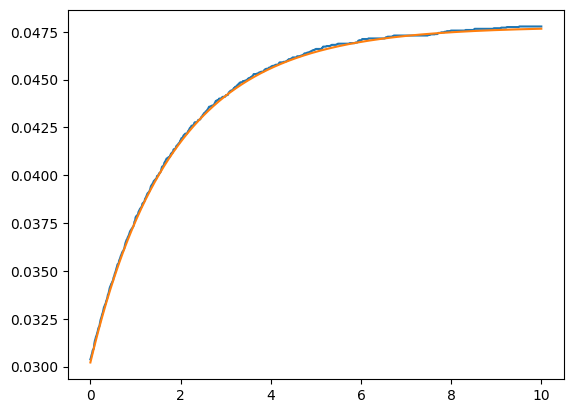

In [5]:

for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
    solver.reset()

    for i in range(time_steps):
        solver.solve(p_target)
        contact_area_result = np.mean(model.traction > 0) * L**2
        normalized_result = contact_area_result / L**2      ######normalized contact area
        Ac_tamaas.append(normalized_result)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * W * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)


    Ac_tamaas = Ac_tamaas[:-1]
    Ac_Johnson_ref = Ac_Johnson_ref[1:]

    print(Ac_tamaas)
    print(Ac_Johnson_ref)
    print(len(Ac_tamaas))
    print(len(Ac_Johnson_ref))

    '''
    # Calculate L2 norm between Ac_tamaas and Ac_Johnson_ref
    L2_error = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))

    # normalize L2 error
    L2_error /= np.sqrt(len(Ac_tamaas))   
    '''
    #L2_error = np.linalg.norm(np.array(Ac_tamaas) - np.array(Ac_Johnson_ref)) / np.sqrt(len(Ac_tamaas))
    L2_norm = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
    error = L2_norm / np.linalg.norm(Ac_Johnson_ref) 
    error_list.append(error)
    #L2_norms.append(L2_error)
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_tamaas, label='Tamaas')
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_Johnson_ref, label='Johnson')
    plt.show()


In [6]:
print(error_list)

[np.float64(0.04124937278541024), np.float64(0.025249014146563862), np.float64(0.014008263128913912), np.float64(0.007235517637277546), np.float64(0.0032881648626548188), np.float64(0.0016681721616153753), np.float64(0.0013611143402834471), np.float64(0.0016492777763589075), np.float64(0.0018895482217006392), np.float64(0.0020388313404353224)]


[np.float64(2.5), np.float64(1.4285714285714286), np.float64(0.8333333333333334), np.float64(0.43478260869565216), np.float64(0.23809523809523808), np.float64(0.13333333333333333), np.float64(0.07352941176470588), np.float64(0.04065040650406504), np.float64(0.02252252252252252), np.float64(0.0125)]


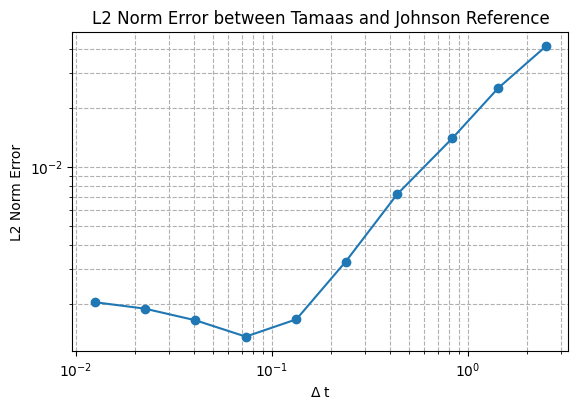

In [7]:
dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]
print(dt_list)
# Plot log-log graph of L2 norms
plt.figure()
plt.loglog(dt_list, error_list, marker='o')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.gca().set_aspect('equal')
plt.show()